# Comprehensions

Esta tabla contiene la información de las comprehensiones.

## 1 - Obtencion de datos

In [1]:
import matplotlib.pyplot as plt
from notebooks_utils import *
from domains import *

full_table = get_data('comprehensions')

# Table name, features and target.
TABLE_NAME = 'comprehensions'
TABLE_FEATURES = ['comprehension__category', 'comprehension__number_of_ifs', 'comprehension__number_of_generators', 'comprehension__is_async', 'comprehension__expertise_level']
TABLE_TARGET = 'comprehension__expertise_level'

# Load features and target.
X, y = full_table[TABLE_FEATURES], full_table[[TABLE_TARGET]].iloc[:,0]

# Print information about the loaded table.
print(f'Features shape: {X.shape}')
print(f'Target shape: {y.shape}')

print(f'As we can see the downloaded data contains a total of {X.shape[0]} instances. For each instance we have {X.shape[1]} attributes.')

2024-07-04 19:21:05.111276 Data cache files found ...
2024-07-04 19:21:05.115275 Data cache files successfully loaded!!
Features shape: (18259, 5)
Target shape: (18259,)
As we can see the downloaded data contains a total of 18259 instances. For each instance we have 5 attributes.


## 2 - Exploracion de datos

Una vez tenemos nuestra tabla en un dataframe el siguiente paso es explorarla para ver qué tipo de información contiene.

In [2]:
print(X.info())
print('=============')
print(y.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18259 entries, 0 to 18258
Data columns (total 5 columns):
 #   Column                               Non-Null Count  Dtype 
---  ------                               --------------  ----- 
 0   comprehension__category              18259 non-null  object
 1   comprehension__number_of_ifs         18259 non-null  int64 
 2   comprehension__number_of_generators  18259 non-null  int64 
 3   comprehension__is_async              18259 non-null  bool  
 4   comprehension__expertise_level       18259 non-null  object
dtypes: bool(1), int64(2), object(2)
memory usage: 588.6+ KB
None
<class 'pandas.core.series.Series'>
RangeIndex: 18259 entries, 0 to 18258
Series name: comprehension__expertise_level
Non-Null Count  Dtype 
--------------  ----- 
18259 non-null  object
dtypes: object(1)
memory usage: 142.8+ KB
None


Cómo podemos ver la tabla está compuesta por 2 variables numéricas, 1 boleanas y 2 de tipo objeto.

### 2.1 - Equilibrado de clases

In [3]:
instances_for_class_low = len(full_table[full_table[TABLE_TARGET] == "BEGINNER"])
instances_for_class_high = len(full_table[full_table[TABLE_TARGET] == "EXPERT"])

print(f"The dataset contains {instances_for_class_low/len(full_table)*100:.4}% instances for BEGINNER class and {instances_for_class_high/len(full_table)*100:.4}% for EXPERT class.")

The dataset contains 27.29% instances for BEGINNER class and 72.71% for EXPERT class.


### 2.2 - Valores Nulos 
Miramos si alguna de las variables que contiene la tabla contiene algún valor que sea nulo.

In [4]:
X.isnull().sum()

comprehension__category                0
comprehension__number_of_ifs           0
comprehension__number_of_generators    0
comprehension__is_async                0
comprehension__expertise_level         0
dtype: int64

In [5]:
print_empty_cols(X)

comprehension__category
-----------------------
0 instancias no tienen un valor para la columna comprehension__category


comprehension__number_of_ifs
----------------------------
0 instancias no tienen un valor para la columna comprehension__number_of_ifs


comprehension__number_of_generators
-----------------------------------
0 instancias no tienen un valor para la columna comprehension__number_of_generators


comprehension__is_async
-----------------------
0 instancias no tienen un valor para la columna comprehension__is_async


comprehension__expertise_level
------------------------------
0 instancias no tienen un valor para la columna comprehension__expertise_level




### 2.3 - Describimos los valores de las variables de la tabla.

In [6]:
np.transpose(X.describe(percentiles=[.25, .50, .75], include = ['object', 'float', 'bool', 'int']))

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
comprehension__category,18259,4,ListComprehension,11602,NaN,NaN,NaN,NaN,NaN,NaN,NaN
comprehension__number_of_ifs,18259.0,NaN,NaN,NaN,0.151542,0.359654,0.0,0.0,0.0,0.0,2.0
comprehension__number_of_generators,18259.0,NaN,NaN,NaN,1.01884,0.14531,1.0,1.0,1.0,1.0,4.0
comprehension__is_async,18259,2,False,18247,NaN,NaN,NaN,NaN,NaN,NaN,NaN
comprehension__expertise_level,18259,2,EXPERT,13277,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Vamos a discretizar las variables numericas, agrupando conjuntos de valores en categorias, para hacer un análisis de los datos. Para cada variable es necesaario ver la distribucion de lo valores para hacer los bins (categorias).

In [7]:
# DISCRETIZATION
X_copy = X.copy()

discretized_columns = {
    "comprehension__number_of_ifs": [(0.0, 0.0), (0.0, inf)],  # min: 0.0 max: 2.0
    "comprehension__number_of_generators": [(0.0, 1.0), (1.0, 1.0), (1.0, inf)],  # min: 1.0 max: 4.0
}

discretize_columns(X_copy, discretized_columns)
    
# SINGLE FEATURE
print("--- SINGLE FEATURE ---")
print(get_statistics(X_copy, ['comprehension__number_of_ifs'], 10))
print(get_statistics(X_copy, ['comprehension__number_of_generators'], 10))
print(get_statistics(full_table, ['comprehension__category'], 10))
print(get_statistics(X_copy, ['comprehension__is_async'], 10))


# 2 FEATURES
print("--- TWO FEATURES ---")
#print(get_statistics(X_copy, ['module__function_defs_pct', 'module__number_of_classes'], 10))

# 3 FEATURES
print("--- THREE FEATURES ---")
#print(get_statistics(X_copy, ['module__class_defs_pct', 'module__function_defs_pct', 'module__enum_defs_pct'], 10))

--- SINGLE FEATURE ---
comprehension__number_of_ifs  count  percentage
                   [0.0_0.0]  15499   84.884167
                   [0.0_inf]   2760   15.115833

comprehension__number_of_generators  count  percentage
                          [1.0_1.0]  17936   98.231009
                          [1.0_inf]    323    1.768991

comprehension__category  count  percentage
      ListComprehension  11602   63.541267
 GeneratorComprehension   4777   26.162440
      DictComprehension   1459    7.990580
       SetComprehension    421    2.305712

 comprehension__is_async  count  percentage
                   False  18247   99.934279
                    True     12    0.065721

--- TWO FEATURES ---
--- THREE FEATURES ---


In [8]:
def normalize_datatypes(X:pd.DataFrame, y:pd.Series) -> (pd.DataFrame, pd.Series, [str]):
    X = pd.get_dummies(X)
    X = X.astype('float32')
    y = y.apply(lambda value: 0 if value == "BEGINNER" else 1) # EXPERT will be 1 and BEGINNER will be 0.
    y = y.astype('float32')
    columns_names = X.columns.tolist()
    return X, y, columns_names

X, y, TABLE_FEATURES = normalize_datatypes(X, y)
# Print information about the loaded table
print(f'Features shape: {X.shape}')
print(f'Target shape: {y.shape}')

Features shape: (18259, 9)
Target shape: (18259,)


#### Muestra la matriz de correlación de Spearman entre las variables de la tabla.

<Axes: >

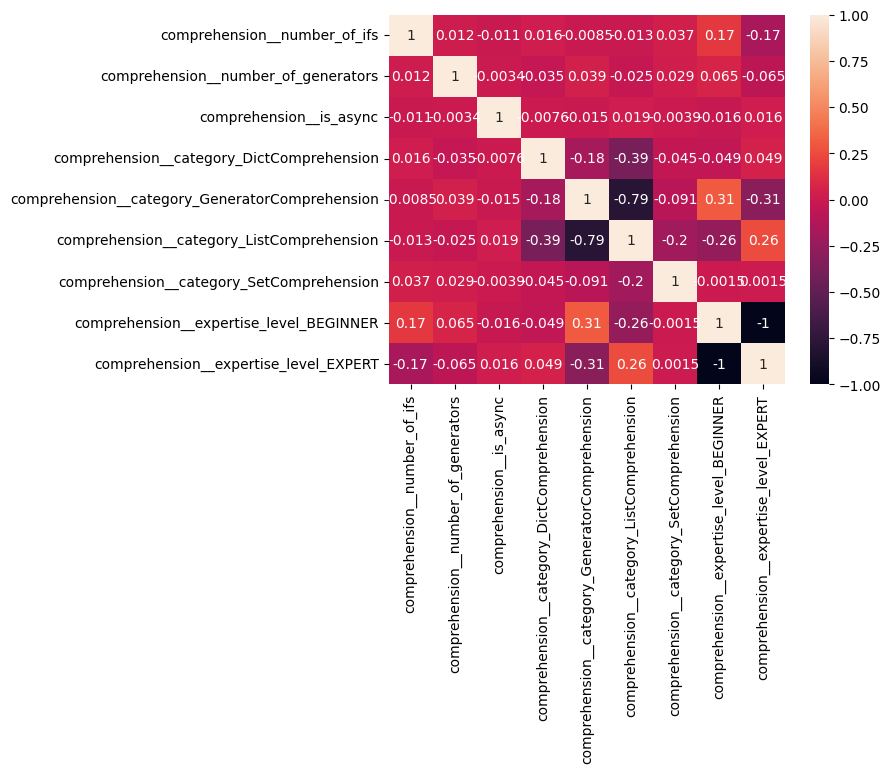

In [9]:
sns.heatmap(X.corr(method='spearman'), annot=True)

## 3 - Detección de valores atípicos (outliers)
## Univariate
## Analisis detallado de variables
Para cada una de las 4 variable (1 booleanas, 2 numericas y 1 categóricas) se hara un analisis detallado

### Variable is_async (1/4)
Esta variable es de tipo booleano y representa si la comprehension es asincrona. El primer paso es hacer un análisis visual de como se distribuyen los valores de la variable.

<Axes: xlabel='comprehension__is_async', ylabel='Count'>

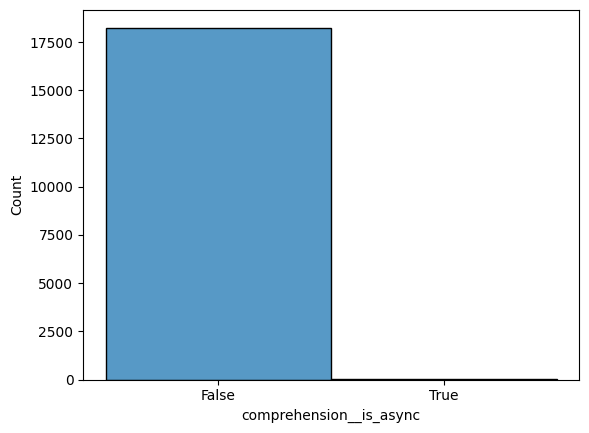

In [10]:
plt.xticks([0, 1], ['False', 'True'])
sns.histplot(X['comprehension__is_async'], discrete=True)

In [11]:
num_true_values = len(X[X['comprehension__is_async'] == True])
num_false_values = len(X[X['comprehension__is_async'] == False])
std = X['comprehension__is_async'].std()
freq_true = len(X[X['comprehension__is_async'] == True]) / len(X['comprehension__is_async'])
freq_false = len(X[X['comprehension__is_async'] == False]) / len(X['comprehension__is_async'])
print(f'La variable is_async contiene {num_true_values} valores verdaderos y {num_false_values} valores falsos. Y, la desviación típica es de {std}')
print(f'La frecuencia con la que programa puede tener la variable is_async a True es {freq_true}.')
print(f'La frecuencia con la que programa puede tener la variable is_async a False es {freq_false}.')

La variable is_async contiene 12 valores verdaderos y 18247 valores falsos. Y, la desviación típica es de 0.025628386065363884
La frecuencia con la que programa puede tener la variable is_async a True es 0.0006572101429432061.
La frecuencia con la que programa puede tener la variable is_async a False es 0.9993427898570568.


In [12]:
possible_values = [True, False]
print_frequency_anal_for_cat_var(X, 'comprehension__is_async', possible_values)

La variable comprehension__is_async contiene 2 valores distintos.
El umbral de outlier es de 0.1%
La variable comprehension__is_async toma el valor de 0.0 en un 99.93% de los items.
La variable comprehension__is_async toma el valor de 1.0 en un 0.06572% de los items. [OUTLIER]


In [13]:
X[X['comprehension__is_async'] == True].describe(percentiles=[.25, .50, .75], include = ['object', 'float', 'bool', 'int'])

,comprehension__number_of_ifs,comprehension__number_of_generators,comprehension__is_async,comprehension__category_DictComprehension,comprehension__category_GeneratorComprehension,comprehension__category_ListComprehension,comprehension__category_SetComprehension,comprehension__expertise_level_BEGINNER,comprehension__expertise_level_EXPERT
count,12.0,12.0,12.0,12.0,12.0,12.0,12.0,12.0,12.0
mean,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0
std,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
min,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0
25%,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0
50%,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0
75%,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0
max,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0


### IMPORTANTE
El valor true en este caso es outlier.

De los pocos comprehension que son asincronas, el 100% es de expertos

### Variable number_of_ifs (2/4)
Esta variable representa el número de clausulas if en la comprehension. Como vimos en la descripción de la tabla esta varibale adopta valores en el rango 0 - 2. Con una media de 0.155.

<Axes: ylabel='comprehension__number_of_ifs'>

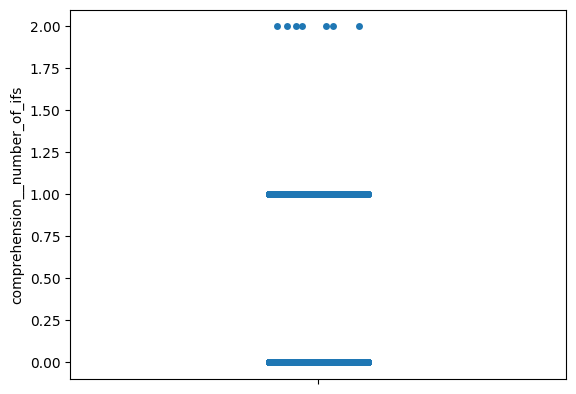

In [14]:
sns.stripplot(X['comprehension__number_of_ifs'])

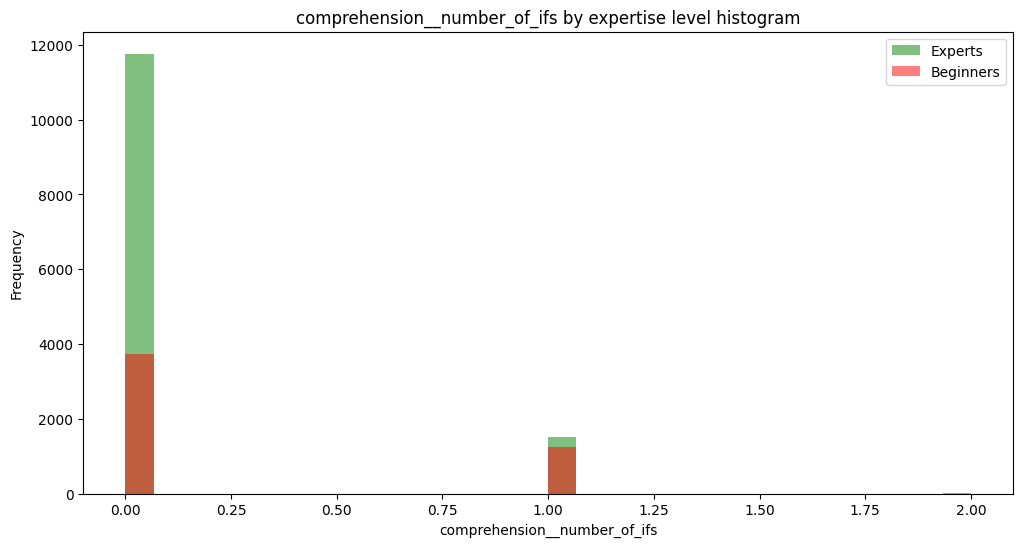

In [15]:
print_histogram(X, 'comprehension__number_of_ifs', 'comprehension__expertise_level', bins=30, include_all=False)

In [16]:
print_outliers_for_df_column(X, 'comprehension__number_of_ifs')

El coeficiente MC (Medcouple Coefficient) de balanceo es: 0.7514372000524898
Rango valores atípicos extremos (Tukey): [0.0,0.0]
Rango valores atípicos leves (Tukey): [0.0,0.0]
Rango valores atípicos extremos (Fixed BoxPlot): [0.0,0.0]
-3.0IQR: 0 instancias tienen un valor para comprehension__number_of_ifs inferior a 0.0 (Q1-3*IQR) para comprehension__number_of_ifs. Representando un 0.0% del total de instancias.
-1.5IQR: 0 instancias tienen un valor para comprehension__number_of_ifs inferior a 0.0 (Q1-1.5*IQR) para comprehension__number_of_ifs. Representando un 0.0% del total de instancias.
+1.5IQR: 2760 instancias tienen un valor para comprehension__number_of_ifs superior a 0.0 (Q3+1.5*IQR) para comprehension__number_of_ifs. Representando un 15.12% del total de instancias.
+3.0IQR: 2760 instancias tienen un valor para comprehension__number_of_ifs superior a 0.0 (Q3-3*IQR) para comprehension__number_of_ifs. Representando un 15.12% del total de instancias.
L: 0 instancias tienen un valor

Describimos los valores de las variables de la tabla, cuando el valor de la variable es mayor que 0 (Todos los umbrales son 0)

In [17]:
X[X['comprehension__number_of_ifs'] > 0].describe(percentiles=[.25, .50, .75], include = ['object', 'float', 'bool', 'int'])

,comprehension__number_of_ifs,comprehension__number_of_generators,comprehension__is_async,comprehension__category_DictComprehension,comprehension__category_GeneratorComprehension,comprehension__category_ListComprehension,comprehension__category_SetComprehension,comprehension__expertise_level_BEGINNER,comprehension__expertise_level_EXPERT
count,2760.000000,2760.000000,2760.0,2760.000000,2760.000000,2760.000000,2760.000000,2760.000000,2760.000000
mean,1.002536,1.021014,0.0,0.090217,0.252536,0.621014,0.036232,0.452536,0.547464
std,0.050306,0.143459,0.0,0.286545,0.434546,0.485222,0.186900,0.497832,0.497832
min,1.000000,1.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.000000,1.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1.000000,1.000000,0.0,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000
75%,1.000000,1.000000,0.0,0.000000,1.000000,1.000000,0.000000,1.000000,1.000000
max,2.000000,2.000000,0.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


### Variable number_of_generators (3/4)
Esta variable representa el número generators presentes en la comprehension. Como vimos en la descripción de la tabla esta varibale adopta valores en el rango 1 - 4. Con una media de 1.019.

<Axes: ylabel='comprehension__number_of_generators'>

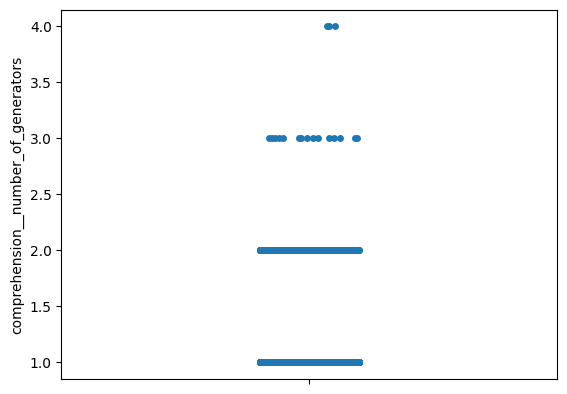

In [18]:
sns.stripplot(X['comprehension__number_of_generators'])

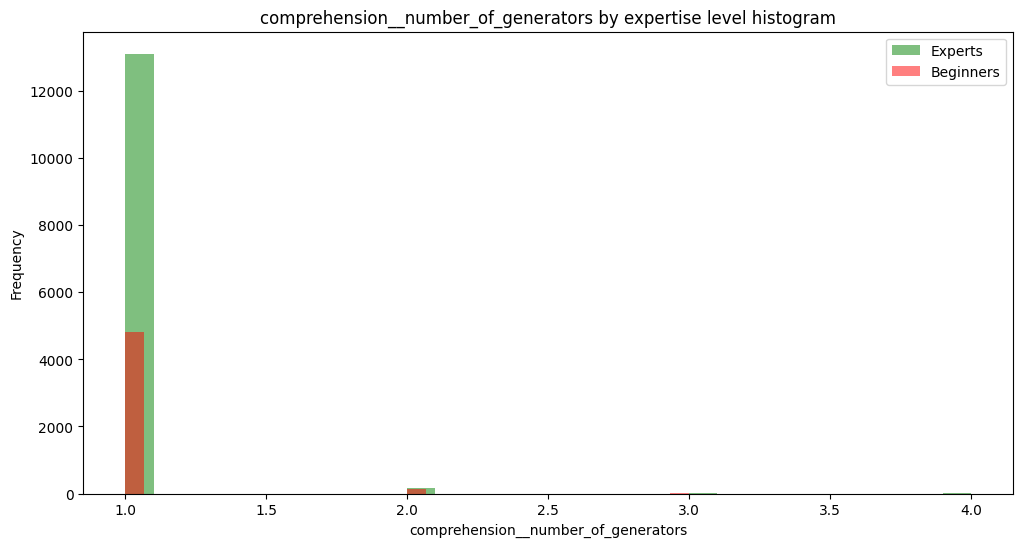

In [19]:
print_histogram(X, 'comprehension__number_of_generators', 'comprehension__expertise_level', bins=30, include_all=False)

In [20]:
print_outliers_for_df_column(X, 'comprehension__number_of_generators')

El coeficiente MC (Medcouple Coefficient) de balanceo es: 1.0
Rango valores atípicos extremos (Tukey): [1.0,1.0]
Rango valores atípicos leves (Tukey): [1.0,1.0]
Rango valores atípicos extremos (Fixed BoxPlot): [1.0,1.0]
-3.0IQR: 0 instancias tienen un valor para comprehension__number_of_generators inferior a 1.0 (Q1-3*IQR) para comprehension__number_of_generators. Representando un 0.0% del total de instancias.
-1.5IQR: 0 instancias tienen un valor para comprehension__number_of_generators inferior a 1.0 (Q1-1.5*IQR) para comprehension__number_of_generators. Representando un 0.0% del total de instancias.
+1.5IQR: 323 instancias tienen un valor para comprehension__number_of_generators superior a 1.0 (Q3+1.5*IQR) para comprehension__number_of_generators. Representando un 1.769% del total de instancias.
+3.0IQR: 323 instancias tienen un valor para comprehension__number_of_generators superior a 1.0 (Q3-3*IQR) para comprehension__number_of_generators. Representando un 1.769% del total de inst

Describimos los valores de las variables de la tabla, cuando el valor de la variable es mayor que 1 (Todos los umbrales son 1)

In [21]:
X[X['comprehension__number_of_generators'] > 1].describe(percentiles=[.25, .50, .75], include = ['object', 'float', 'bool', 'int'])

,comprehension__number_of_ifs,comprehension__number_of_generators,comprehension__is_async,comprehension__category_DictComprehension,comprehension__category_GeneratorComprehension,comprehension__category_ListComprehension,comprehension__category_SetComprehension,comprehension__expertise_level_BEGINNER,comprehension__expertise_level_EXPERT
count,323.000000,323.000000,323.0,323.000000,323.000000,323.000000,323.000000,323.000000,323.000000
mean,0.198142,2.065016,0.0,0.009288,0.390093,0.544892,0.055728,0.489164,0.510836
std,0.443444,0.282154,0.0,0.096074,0.488528,0.498753,0.229751,0.500658,0.500658
min,0.000000,2.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,2.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,2.000000,0.0,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000
75%,0.000000,2.000000,0.0,0.000000,1.000000,1.000000,0.000000,1.000000,1.000000
max,2.000000,4.000000,0.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


### Variable category (4/4)
Esta variable es de tipo categórica y representa el tipo de comprehension.

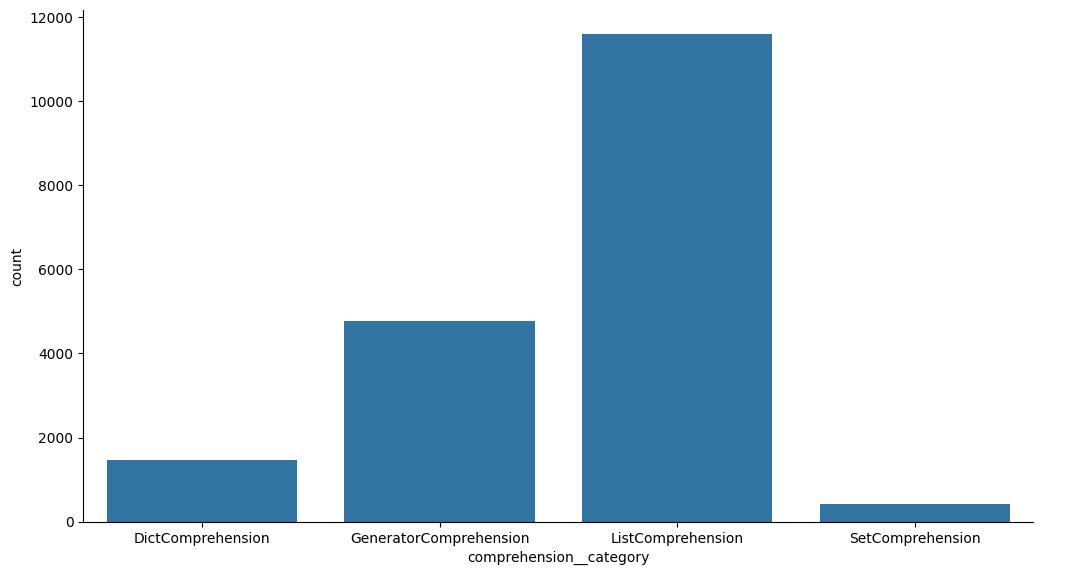

In [22]:
print_categorical_histogram(full_table, 'comprehension__category')

In [23]:
print_frequency_anal_for_cat_var(full_table, 'comprehension__category')

La variable comprehension__category contiene 4 valores distintos.
El umbral de outlier es de 0.05%
La variable comprehension__category toma el valor de ListComprehension en un 63.54% de los items.
La variable comprehension__category toma el valor de GeneratorComprehension en un 26.16% de los items.
La variable comprehension__category toma el valor de DictComprehension en un 7.991% de los items.
La variable comprehension__category toma el valor de SetComprehension en un 2.306% de los items.


In [24]:
print_values_usage_for_cat_var(full_table, 'comprehension__category', COMPREHENSION_CATEGORY_VALUES)

La variable comprehension__category puede tomar 4 valores distintos
	4 (100.0%) valores utilizados
	0 (0.0%) valores NO utilizados


## Multivariate

Isolation forest algorithm

In [25]:
from sklearn.ensemble import  IsolationForest

CONTAMINATION_FACTOR = 0.0012
isof_model = IsolationForest(contamination=CONTAMINATION_FACTOR, random_state=0)
isof_prediction = isof_model.fit_predict(X.values)
mask = isof_prediction == -1
full_table.loc[X.index[mask]]

,comprehension__category,comprehension__number_of_ifs,comprehension__number_of_generators,comprehension__is_async,comprehension__expertise_level
115,SetComprehension,0,3,False,BEGINNER
1061,SetComprehension,0,3,False,BEGINNER
1093,SetComprehension,0,2,False,BEGINNER
1869,SetComprehension,0,3,False,BEGINNER
1901,SetComprehension,0,2,False,BEGINNER
2677,SetComprehension,0,3,False,BEGINNER
2709,SetComprehension,0,2,False,BEGINNER
3486,SetComprehension,0,3,False,BEGINNER
3518,SetComprehension,0,2,False,BEGINNER
4291,SetComprehension,0,3,False,BEGINNER


### IMPORTANTE
Revisar los 21 outliers detectados

In [26]:
# Outliers
np.transpose(X[mask].describe(percentiles=[.25, .50, .75], include = ['object', 'float', 'bool', 'int']))

,count,mean,std,min,25%,50%,75%,max
comprehension__number_of_ifs,21.0,0.285714,0.462910,0.0,0.0,0.0,1.0,1.0
comprehension__number_of_generators,21.0,2.285714,0.462910,2.0,2.0,2.0,3.0,3.0
comprehension__is_async,21.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
comprehension__category_DictComprehension,21.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
comprehension__category_GeneratorComprehension,21.0,0.142857,0.358569,0.0,0.0,0.0,0.0,1.0
comprehension__category_ListComprehension,21.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
comprehension__category_SetComprehension,21.0,0.857143,0.358569,0.0,1.0,1.0,1.0,1.0
comprehension__expertise_level_BEGINNER,21.0,0.523810,0.511766,0.0,0.0,1.0,1.0,1.0
comprehension__expertise_level_EXPERT,21.0,0.476190,0.511766,0.0,0.0,0.0,1.0,1.0


In [27]:
# Non-Outliers
np.transpose(X[~mask].describe(percentiles=[.25, .50, .75], include = ['object', 'float', 'bool', 'int']))

,count,mean,std,min,25%,50%,75%,max
comprehension__number_of_ifs,18238.0,0.151387,0.359505,0.0,0.0,0.0,0.0,2.0
comprehension__number_of_generators,18238.0,1.017381,0.138037,1.0,1.0,1.0,1.0,4.0
comprehension__is_async,18238.0,0.000658,0.025643,0.0,0.0,0.0,0.0,1.0
comprehension__category_DictComprehension,18238.0,0.079998,0.271297,0.0,0.0,0.0,0.0,1.0
comprehension__category_GeneratorComprehension,18238.0,0.261761,0.439605,0.0,0.0,0.0,1.0,1.0
comprehension__category_ListComprehension,18238.0,0.636144,0.481121,0.0,0.0,1.0,1.0,1.0
comprehension__category_SetComprehension,18238.0,0.022097,0.147002,0.0,0.0,0.0,0.0,1.0
comprehension__expertise_level_BEGINNER,18238.0,0.272563,0.445290,0.0,0.0,0.0,1.0,1.0
comprehension__expertise_level_EXPERT,18238.0,0.727437,0.445290,0.0,0.0,1.0,1.0,1.0
